<a href="https://colab.research.google.com/github/ThaoPham96/DeepARV/blob/main/DeepARV_Sim_revised_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DeepARV: Ensemble Deep Learning to Predict Drug-Drug Interaction (DDI) of Clinical Relevance with Antiretrovial Therapy (ARV)**

In this study, we built an esemble learning algorithm to predict DDIs of clinical relevance between ARVs and comedications.

DDI severity grading between 29,142 drug pairs was extracted from the Liverpool HIV Drug Interaction database, https://www.hiv-druginteractions.org/. Molecular structure of each drug was converted to Morgan fingerprints where each atom was represented in a numerical format and compared by constructing drug similarity profiles. We developed DeepARV, a feed-forward neural network where drug similarity profiles were fed into the input layer and outputted 4 categories of DDI as 'traffic light' system:

*   Red: drugs should not be co-administered
*   Amber: interaction of potential clinical relevance manageable by monitoring/dose adjustment
*   Yellow: interaction of weak relevance
*   Green: no expected interaction

The imbalance in the distribution of DDI severity grades was addressed by undersampling and applying ensemble learning during training of DeepARV.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and installations

In [20]:
!pip install tensorboard
!pip install tensorflow_addons

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.callbacks import Callback
import tensorflow.experimental.numpy as tnp
import math
import timeit
import datetime, os
import pandas as pd
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.utils import class_weight
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm import tqdm
from deep_arv_utils import *
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# DeepARV Class

In [21]:
def get_weighted_metrics(y_pred, y_test):
    confusion_matrix = tf.math.confusion_matrix(y_test,y_pred, 4)
    num_instances_per_class = np.bincount(y_test)
    TP = np.diag(confusion_matrix)
    FP = np.sum(confusion_matrix, axis=0) - TP
    FN = np.sum(confusion_matrix, axis=1) - TP
    TN = np.sum(confusion_matrix) - (TP + FP + FN)

    accuracy = (TP + TN)/(TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    balanced_accuracy = (sensitivity + specificity) / 2

    # Calculate weighted averages
    weighted_avg_precision = (np.sum(precision * num_instances_per_class) /
                             np.sum(num_instances_per_class))
    weighted_avg_sensitivity = (np.sum(sensitivity * num_instances_per_class) /
                                np.sum(num_instances_per_class))
    weighted_avg_specificity = (np.sum(specificity * num_instances_per_class) /
                                np.sum(num_instances_per_class))
    weighted_avg_f1_score = (np.sum(f1_score * num_instances_per_class) /
                             np.sum(num_instances_per_class))
    weighted_avg_balanced_accuracy = (np.sum(balanced_accuracy *
                                            num_instances_per_class) /
                                      np.sum(num_instances_per_class))
    macro_accuracy = np.mean(accuracy, axis=0)
    weighted_array = np.array([macro_accuracy, weighted_avg_precision,
                               weighted_avg_sensitivity, weighted_avg_specificity,
                          weighted_avg_f1_score, weighted_avg_balanced_accuracy])
    metrics_sum = np.vstack((accuracy, precision, sensitivity, specificity,
                            f1_score, balanced_accuracy)).T
    metrics_update = np.vstack((metrics_sum,weighted_array))

    columns = ['accuracy', 'precision', 'sensitivity', 'specificity',
               'f1-score', 'balanced accuracy']
    rows = ['Green','Yellow', 'Amber', 'Red', 'Weighted']
    df = pd.DataFrame(data = metrics_update, columns = columns, index = pd.Index(rows))
    print("Weighted Avg Precision", weighted_avg_precision)
    print("Weighted Avg Sensitivity", weighted_avg_sensitivity)
    print("Weighted Avg Specificity", weighted_avg_specificity)
    print("Weighted Avg F1 Score", weighted_avg_f1_score)
    print("Weighted Avg Balanced Accuracy", weighted_avg_balanced_accuracy)
    return df

In [26]:
class DeepARV_ensemble:
  ''' Training of DeepARV '''
  def __init__(self, train_df=None, test_df=None, n_models=5):
    # Load data
    self.train_df = train_df
    self.test_ds = test_df
    self.n_models = n_models

  def build_model(self, feature):
    ''' Builds a single model '''
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(feature,))),
    model.add(Dropout(0.2)),
    model.add(Dense(512, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(256, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(128, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(4, activation='softmax'))
    tf.keras.optimizers.Adam(learning_rate=0.001,
                            beta_1=0.9, beta_2=0.999,
                            epsilon=1e-07,
                            amsgrad=False,
                            name='Adam')
    model.compile(optimizer='Adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    self.model = model
    return model

  #Undersample the majority
  def undersample(self ):
      minority = self.train_df[self.train_df.Label != 0]
      majority = self.train_df[self.train_df.Label == 0
                               ].sample(frac=1, random_state=42
                                        ).reset_index(drop=True)
      # Split majority class for undersampling
      majority_dict = split_majority(majority,5,2762)
      train_split_dict = {} #dict to hold final training df
      n_model = 5
      self.undersampled_feature_dict = {}
      self.undersampled_label_dict = {}
      print('\n########################################\n')
      print('---------------------------------------')
      print('DDI 4-fold training distribution BEFORE undersampling : ',
            count_uniques_ddi(self.train_df))
      print('---------------------------------------')
      for i in range(5):
          train_split_dict[i] = pd.concat([majority_dict[i],minority]
                                          ).sample(frac=1,random_state=42
                                          ).reset_index(drop=True)
          print('---------------------------------------')
          print('DDI distribution for training model '+str(i)+
                ' AFTER undersampling: \n',
                count_uniques_ddi(train_split_dict[i]))
          self.undersampled_feature_dict[i] = train_split_dict[i
                                                               ].drop(
                                                              columns='Label')
          self.undersampled_label_dict[i] = train_split_dict[i].Label.dropna()
      return

  def train(self, n_models=5):
        print('\n########################################\n')
        print('Building models, balancing with class weights and training ...\n')
        self.model_dict = {}
        for i in range(n_models):
            print('Training model: ', i)
            class_weights = class_weight.compute_class_weight(
                            class_weight='balanced',
                            classes = np.unique(self.undersampled_label_dict[i]
                                                ),
                            y = self.undersampled_label_dict[i])
            class_weights_model = dict(zip(np.unique(
                                  self.undersampled_label_dict[i]),
                                           class_weights))
            self.model_dict[i] = self.build_model(1376)
            early_stopping = EarlyStopping(monitor='val_loss',
                                           patience=10,
                                           restore_best_weights=True)
            self.model_dict[i].fit(self.undersampled_feature_dict[i],
                                   self.undersampled_label_dict[i],
                                   epochs=30,
                                   validation_split=0.1,
                                   batch_size = 128,
                                   class_weight=class_weights_model,
                                   callbacks=[early_stopping])

  def test(self):
      # Predict from all models
      y_test = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/Y_test_full.npy')
      print('\nPredicting for test set for each model, aggregating for final vote...\n')
      all_results = {}
      for i in range(5):
          all_results[i] = self.model_dict[i].predict(self.test_ds.iloc[:,:-1])

      self.all_results_values = np.array(list(all_results.values()))
      self.soft_vote_mean = self.all_results_values.mean(axis=0)
      self.soft_vote = self.soft_vote_mean.argmax(axis=1)
      y_pred = self.soft_vote
      # Convert class labels to one-hot encoded format
      y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
      # Calculate ROC AUC for each class
      roc_auc_per_class = []
      for i in range(4):
          roc_auc = roc_auc_score(y_test_bin[:, i], self.soft_vote_mean[:, i])
          roc_auc_per_class.append(roc_auc)
      # Average the ROC AUC scores
      average_roc_auc = sum(roc_auc_per_class) / len(roc_auc_per_class)
      print("ROC AUC per class:", roc_auc_per_class)
      print("Average ROC AUC:", average_roc_auc)
      # Calculate accuracy
      print('Evaluation metrics for')
      report = classification_report(y_test, y_pred)
      print(report)
      self.df_vote = pd.DataFrame(data=self.soft_vote, columns=['final_vote'])
      self.each_class_results = get_weighted_metrics(y_pred = y_pred,
                                                     y_test = y_test)

  def visualize_confusion_matrix(self):
    print('\n Plotting confusion matrix ...')
    y_pred = self.df_vote.final_vote
    y_test = self.test_ds['label']
    plot_norm_confusion_matrix(y_pred, y_test)
    plot_confusion_matrix(y_pred, y_test)

  def load_pretrained_models(self, ens):
      self.model_dict = {}
      print('\nLoading pretrained models...\n')
      for i in tqdm(range(self.n_models)):
        self.model_dict[i] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/DeepARV_revised/v2_revised/'+ str(ens) + '/DeepARV_model'+str(i)+'.keras')
      print('\n')



#Evaluation


Positive and negative classifications were defined as a binary classification for every class individually e.g. for Green DDI category: True Positive instances constitute true target Green class predicted as Green; True Negative instances include target class of Yellow, Amber or Red not predicted as Green; False Negative instances are target Green class predicted as either Yellow, Amber or Red; False Positive instances are target class of Yellow, Amber or Red predicted as Green.


## Catplot

In [30]:
def load_independent_test_set():
  print('\nLoading independent test set')
  # Load preprocessed X
  independent_test = pd.DataFrame(np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/X_test_concat.npy'))
  # Load preprocessed Y
  independent_test['label'] = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/Y_test_full.npy')
  print('\nDDI distribution in independent test set')
  print('-------------------------------------------')
  print(count_uniques_ddi(independent_test))
  print('-------------------------------------------\n')
  return independent_test

In [33]:
def DeepARV_evaluation():
  # Load dataset and pretrained models
  ind_test  = load_independent_test_set()
  deepARV_ensemble = DeepARV_ensemble(test_df=ind_test)
  vote = {}
  confidence_score = {}
  all_model_results = {}
  for ens in range(5):
    print('\n DeepARV Iteration ' + str(ens) +' evaluation\n')
    deepARV_ensemble.load_pretrained_models(ens)

    # Test and visualize results from final model
    deepARV_ensemble.test()
    #deepARV_ensemble.df_vote.to_pickle('result_' + str(ens) +'.pkl')
    vote[ens] = deepARV_ensemble.soft_vote
    all_model_results[ens] = np.round(deepARV_ensemble.each_class_results,4)
    #print(deepARV_ensemble.all_results_values)
    confidence_score[ens] = deepARV_ensemble.soft_vote_mean
    deepARV_ensemble.visualize_confusion_matrix()
    print('\n ------------------------------\n')
  return all_model_results, vote, confidence_score


Loading independent test set

DDI distribution in independent test set
-------------------------------------------
  Clinical_label Numeric_label Amount
0          Green             0   3221
1         Yellow             1    358
2          Amber             2   1146
3            Red             3    378
-------------------------------------------


 DeepARV Iteration 0 evaluation


Loading pretrained models...



100%|██████████| 5/5 [00:01<00:00,  2.84it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 1s 7ms/step
ROC AUC per class: [0.8189026516672435, 0.8480835457494216, 0.7249925133227572, 0.9112295288485764]
Average ROC AUC: 0.8258020598969997
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.84      0.70      0.76      3221
           1       0.29      0.63      0.39       358
           2       0.49      0.42      0.45      1146
           3       0.41      0.70      0.52       378

    accuracy                           0.63      5103
   macro avg       0.51      0.61      0.53      5103
weighted avg       0.69      0.63      0.65      5103

Weighted Avg Precision 0.6901445135090208
Weighted Avg Sensitivity 0.6317852243778169
Weighted Avg Specificity 0.8121163741870648
Weighted Avg F1 Score 0.64889711221805
Weighted Avg Balanced Accuracy 0.7219507992824411
Plotting confusion matrix ...

 Plotting confusion matrix 

100%|██████████| 5/5 [00:01<00:00,  4.04it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 1s 7ms/step
ROC AUC per class: [0.8280085919944202, 0.8556354527847603, 0.7396851449769136, 0.8910330057949106]
Average ROC AUC: 0.8285905488877512
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.85      0.67      0.75      3221
           1       0.34      0.54      0.41       358
           2       0.44      0.56      0.49      1146
           3       0.42      0.63      0.51       378

    accuracy                           0.63      5103
   macro avg       0.51      0.60      0.54      5103
weighted avg       0.69      0.63      0.65      5103

Weighted Avg Precision 0.6941867663873709
Weighted Avg Sensitivity 0.6331569664902998
Weighted Avg Specificity 0.8208353886345058
Weighted Avg F1 Score 0.6520690059997102
Weighted Avg Balanced Accuracy 0.7269961775624029
Plotting confusion matrix ...

 Plotting confusion matri

100%|██████████| 5/5 [00:01<00:00,  4.12it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 2s 11ms/step
ROC AUC per class: [0.8389996605037149, 0.8504423945229027, 0.7254488808795776, 0.906142885137594]
Average ROC AUC: 0.8302584552609472
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      3221
           1       0.24      0.72      0.36       358
           2       0.54      0.38      0.45      1146
           3       0.41      0.71      0.52       378

    accuracy                           0.63      5103
   macro avg       0.52      0.63      0.53      5103
weighted avg       0.72      0.63      0.65      5103

Weighted Avg Precision 0.7189168829423408
Weighted Avg Sensitivity 0.6294336664707035
Weighted Avg Specificity 0.8502409144742107
Weighted Avg F1 Score 0.6538005892489722
Weighted Avg Balanced Accuracy 0.739837290472457
Plotting confusion matrix ...

 Plotting confusion matrix

100%|██████████| 5/5 [00:01<00:00,  4.05it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 1s 6ms/step
ROC AUC per class: [0.828625887960947, 0.850150113909967, 0.7184840658368914, 0.8982926009910136]
Average ROC AUC: 0.8238881671747048
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.89      0.52      0.66      3221
           1       0.27      0.65      0.38       358
           2       0.40      0.56      0.47      1146
           3       0.38      0.78      0.52       378

    accuracy                           0.56      5103
   macro avg       0.49      0.63      0.51      5103
weighted avg       0.70      0.56      0.59      5103

Weighted Avg Precision 0.7005319092892719
Weighted Avg Sensitivity 0.5586909660983735
Weighted Avg Specificity 0.86067189035571
Weighted Avg F1 Score 0.585946019162622
Weighted Avg Balanced Accuracy 0.7096814282270418
Plotting confusion matrix ...

 Plotting confusion matrix ...

100%|██████████| 5/5 [00:01<00:00,  3.40it/s]





Predicting for test set for each model, aggregating for final vote...

160/160 [==============================] - 1s 7ms/step
ROC AUC per class: [0.8361704423118608, 0.8543709638490384, 0.7526015927768008, 0.8889048458889728]
Average ROC AUC: 0.8330119612066682
Evaluation metrics for
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      3221
           1       0.30      0.56      0.39       358
           2       0.51      0.50      0.50      1146
           3       0.40      0.71      0.51       378

    accuracy                           0.65      5103
   macro avg       0.52      0.62      0.55      5103
weighted avg       0.71      0.65      0.67      5103

Weighted Avg Precision 0.7117357357750352
Weighted Avg Sensitivity 0.6507936507936508
Weighted Avg Specificity 0.8380701021144816
Weighted Avg F1 Score 0.6701012258259975
Weighted Avg Balanced Accuracy 0.7444318764540663
Plotting confusion matrix ...

 Plotting confusion matri

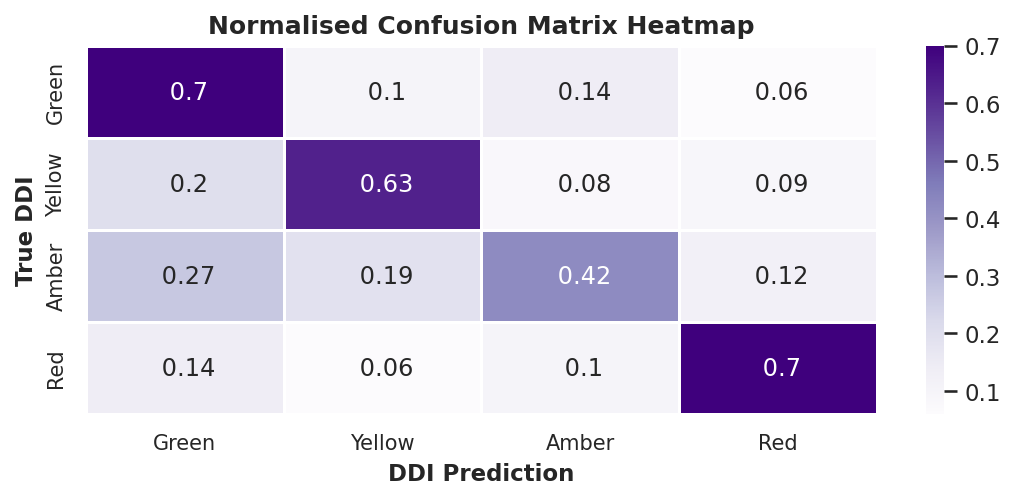

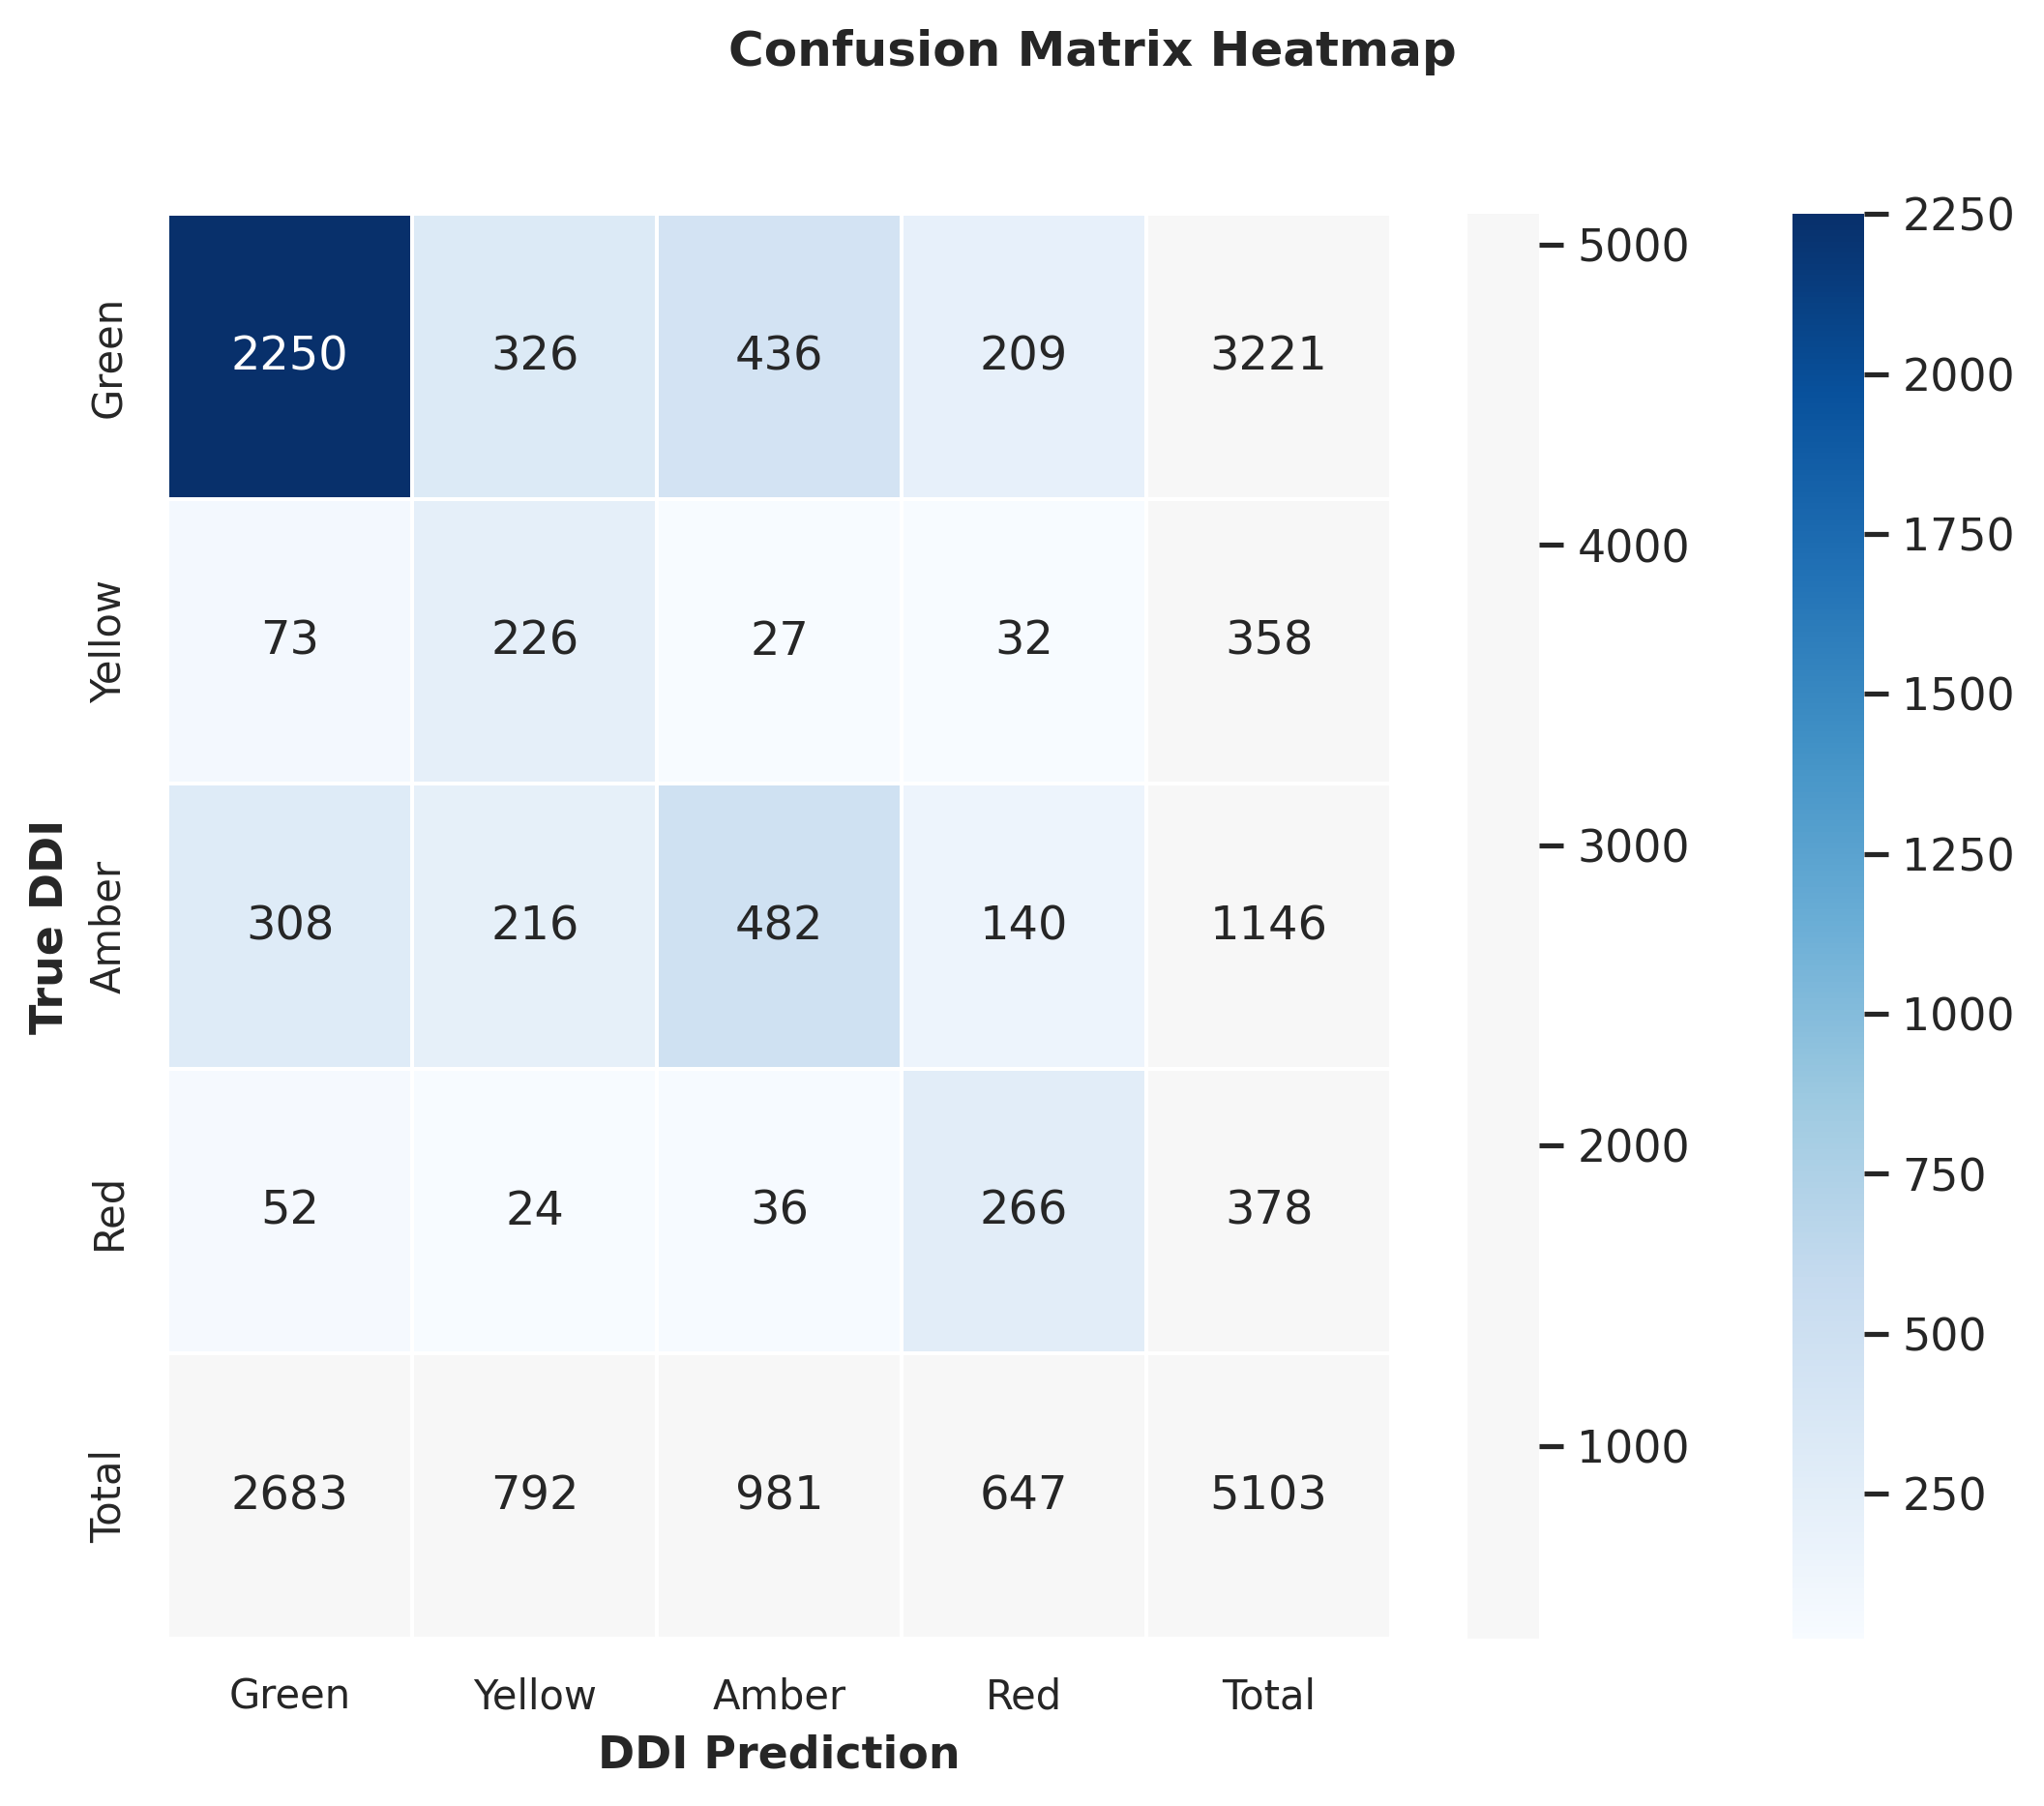

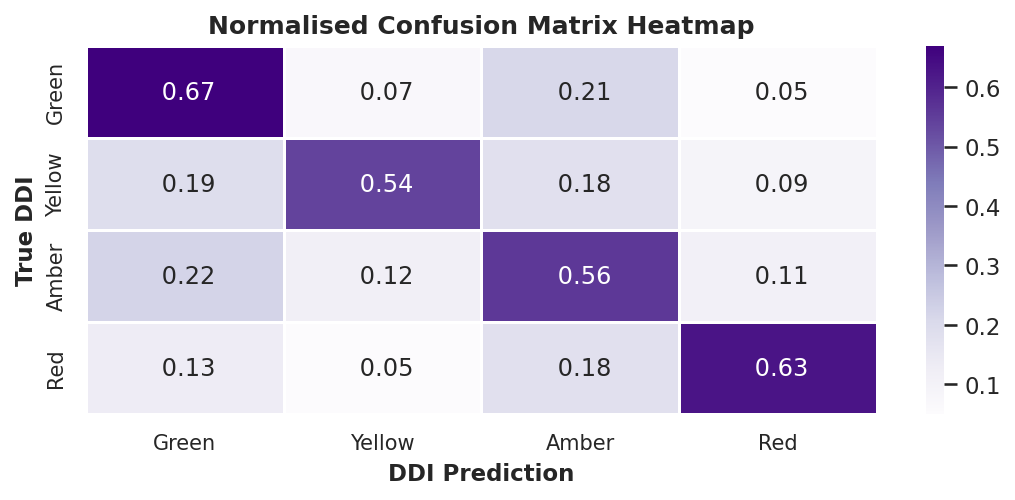

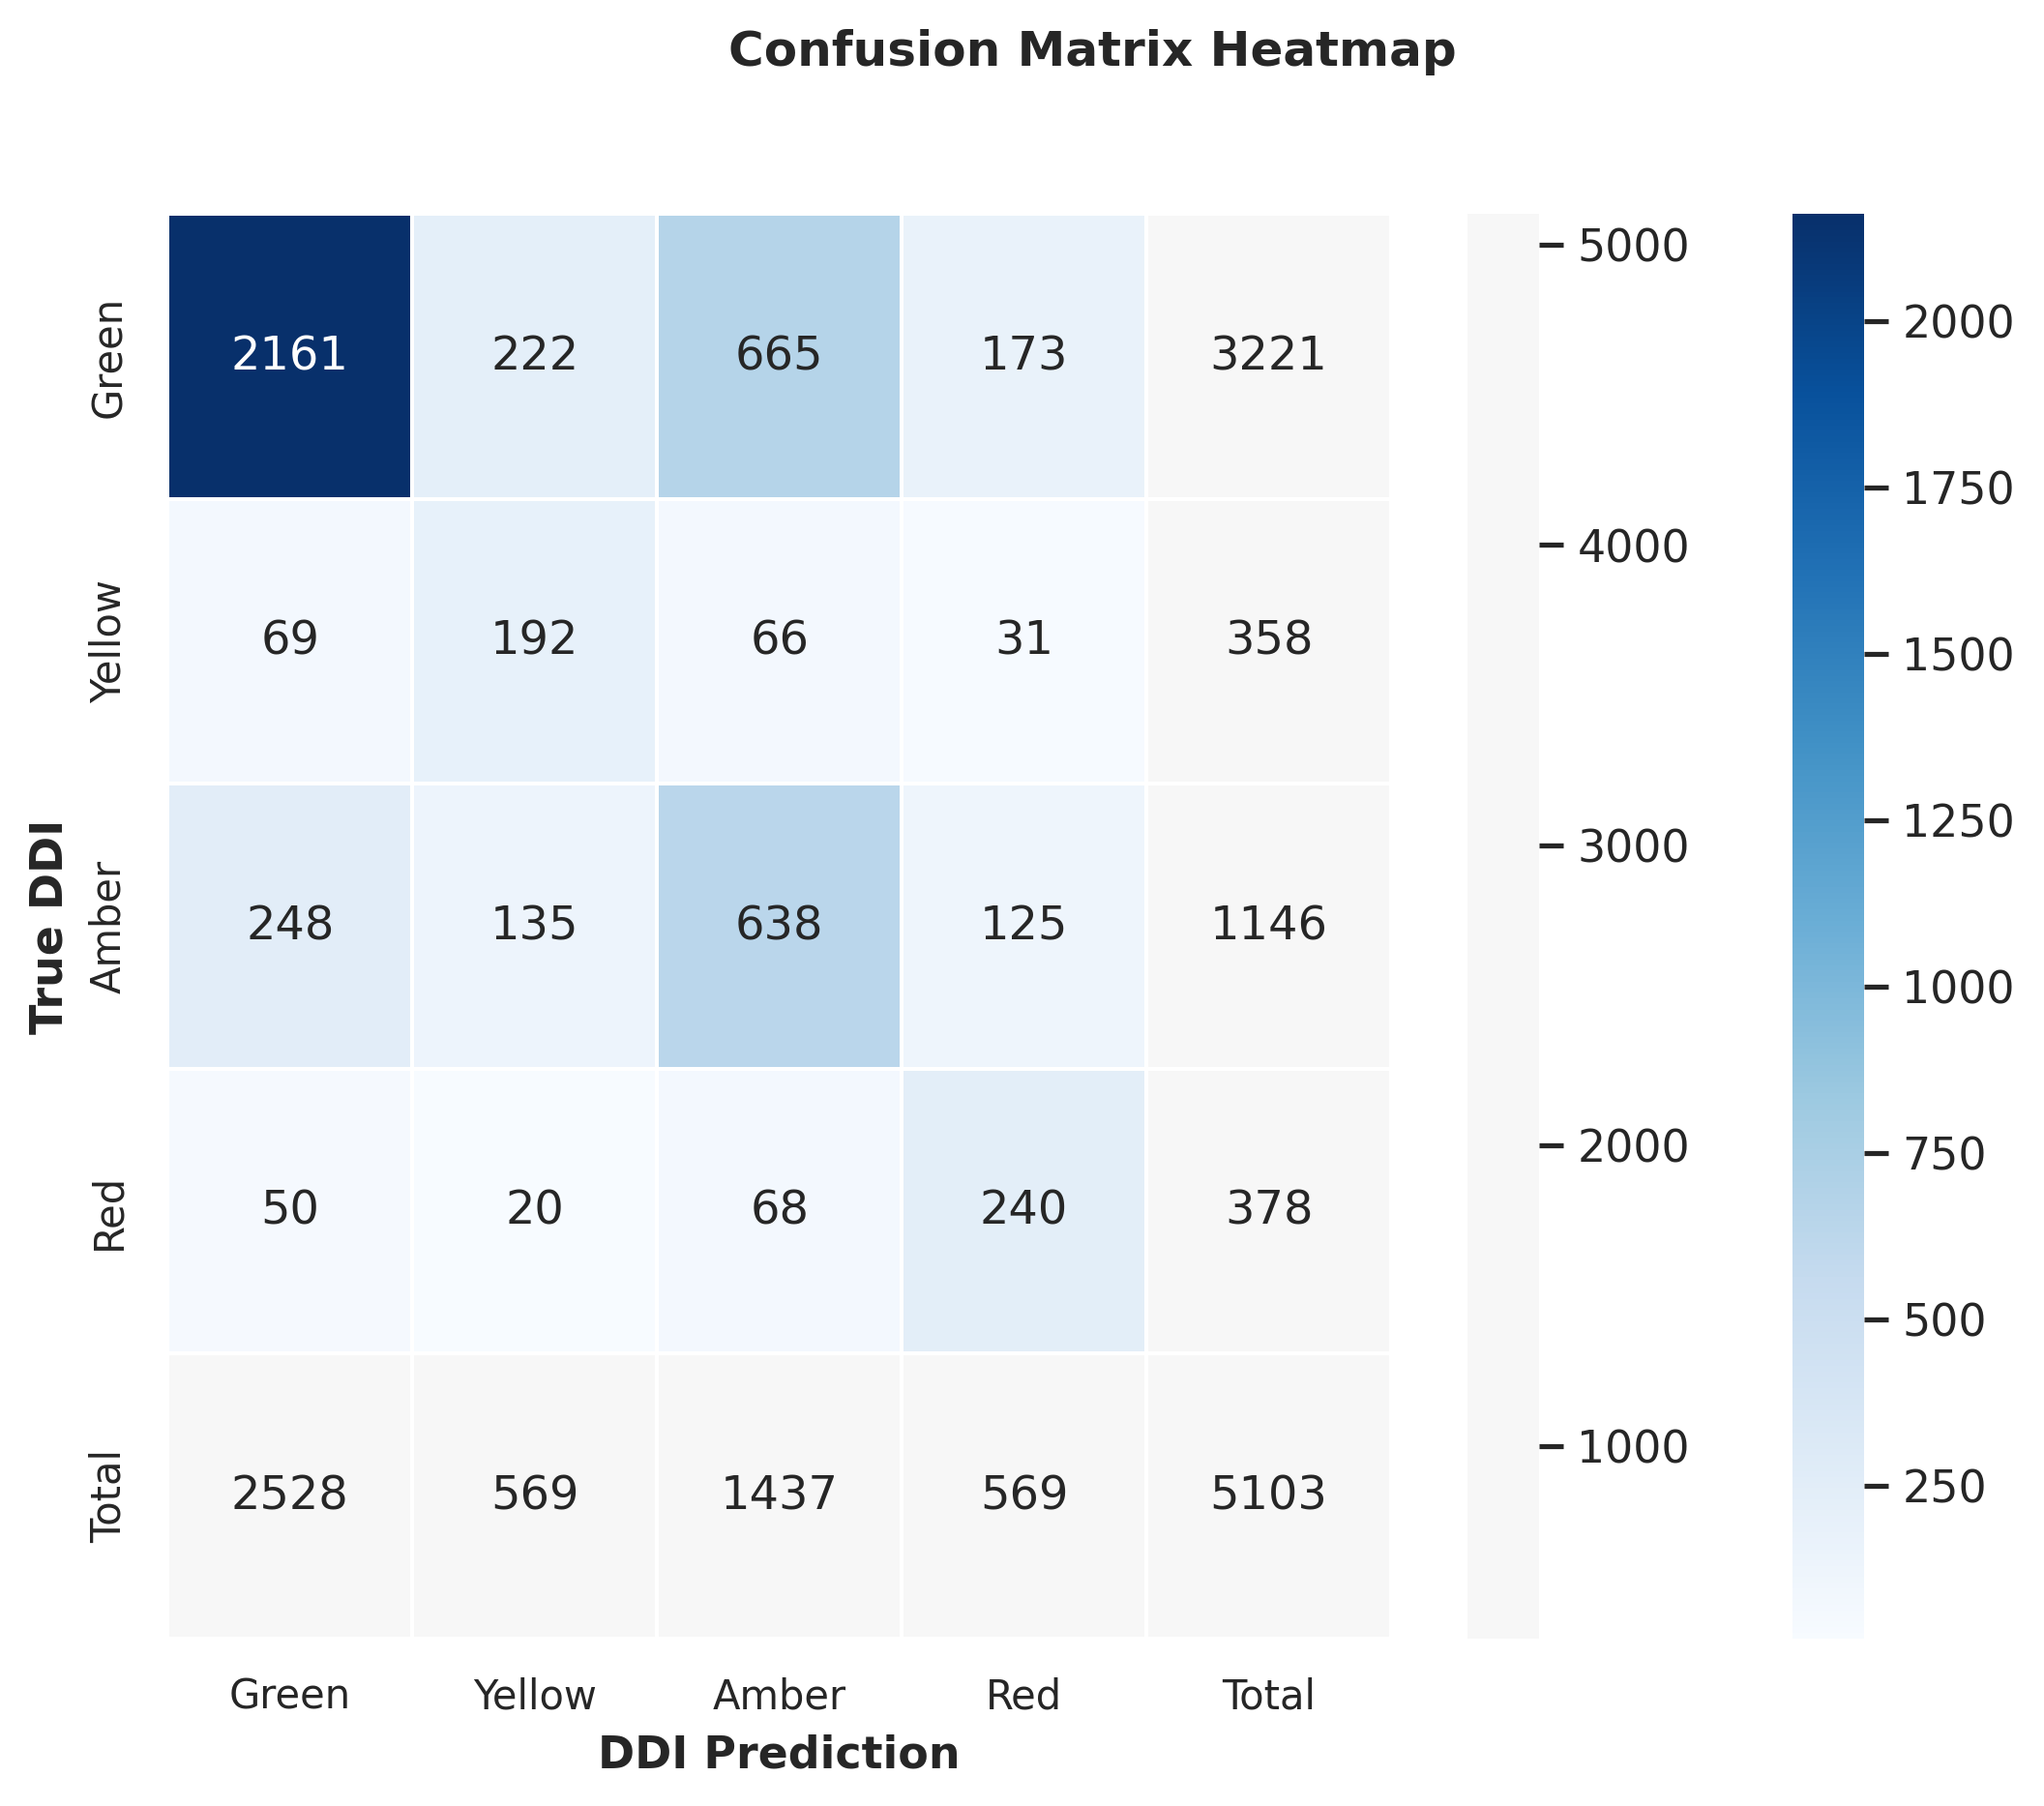

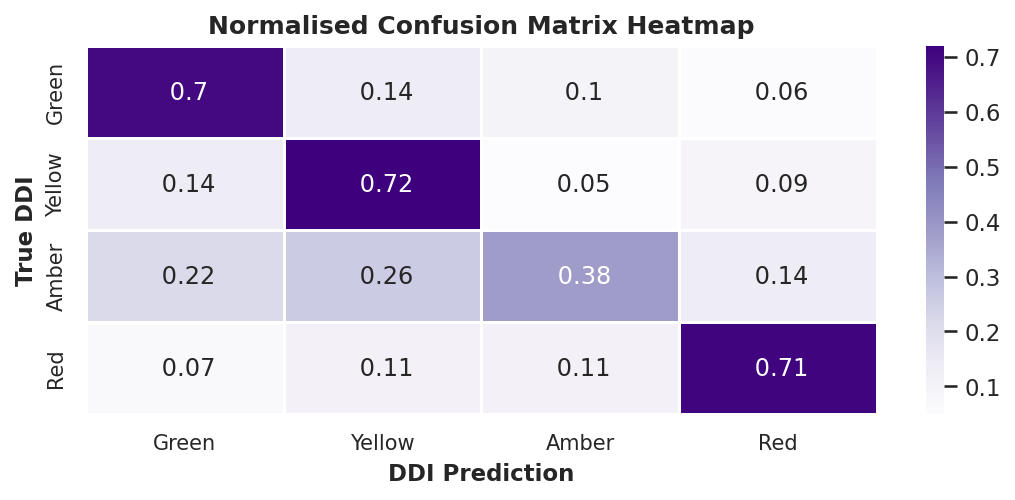

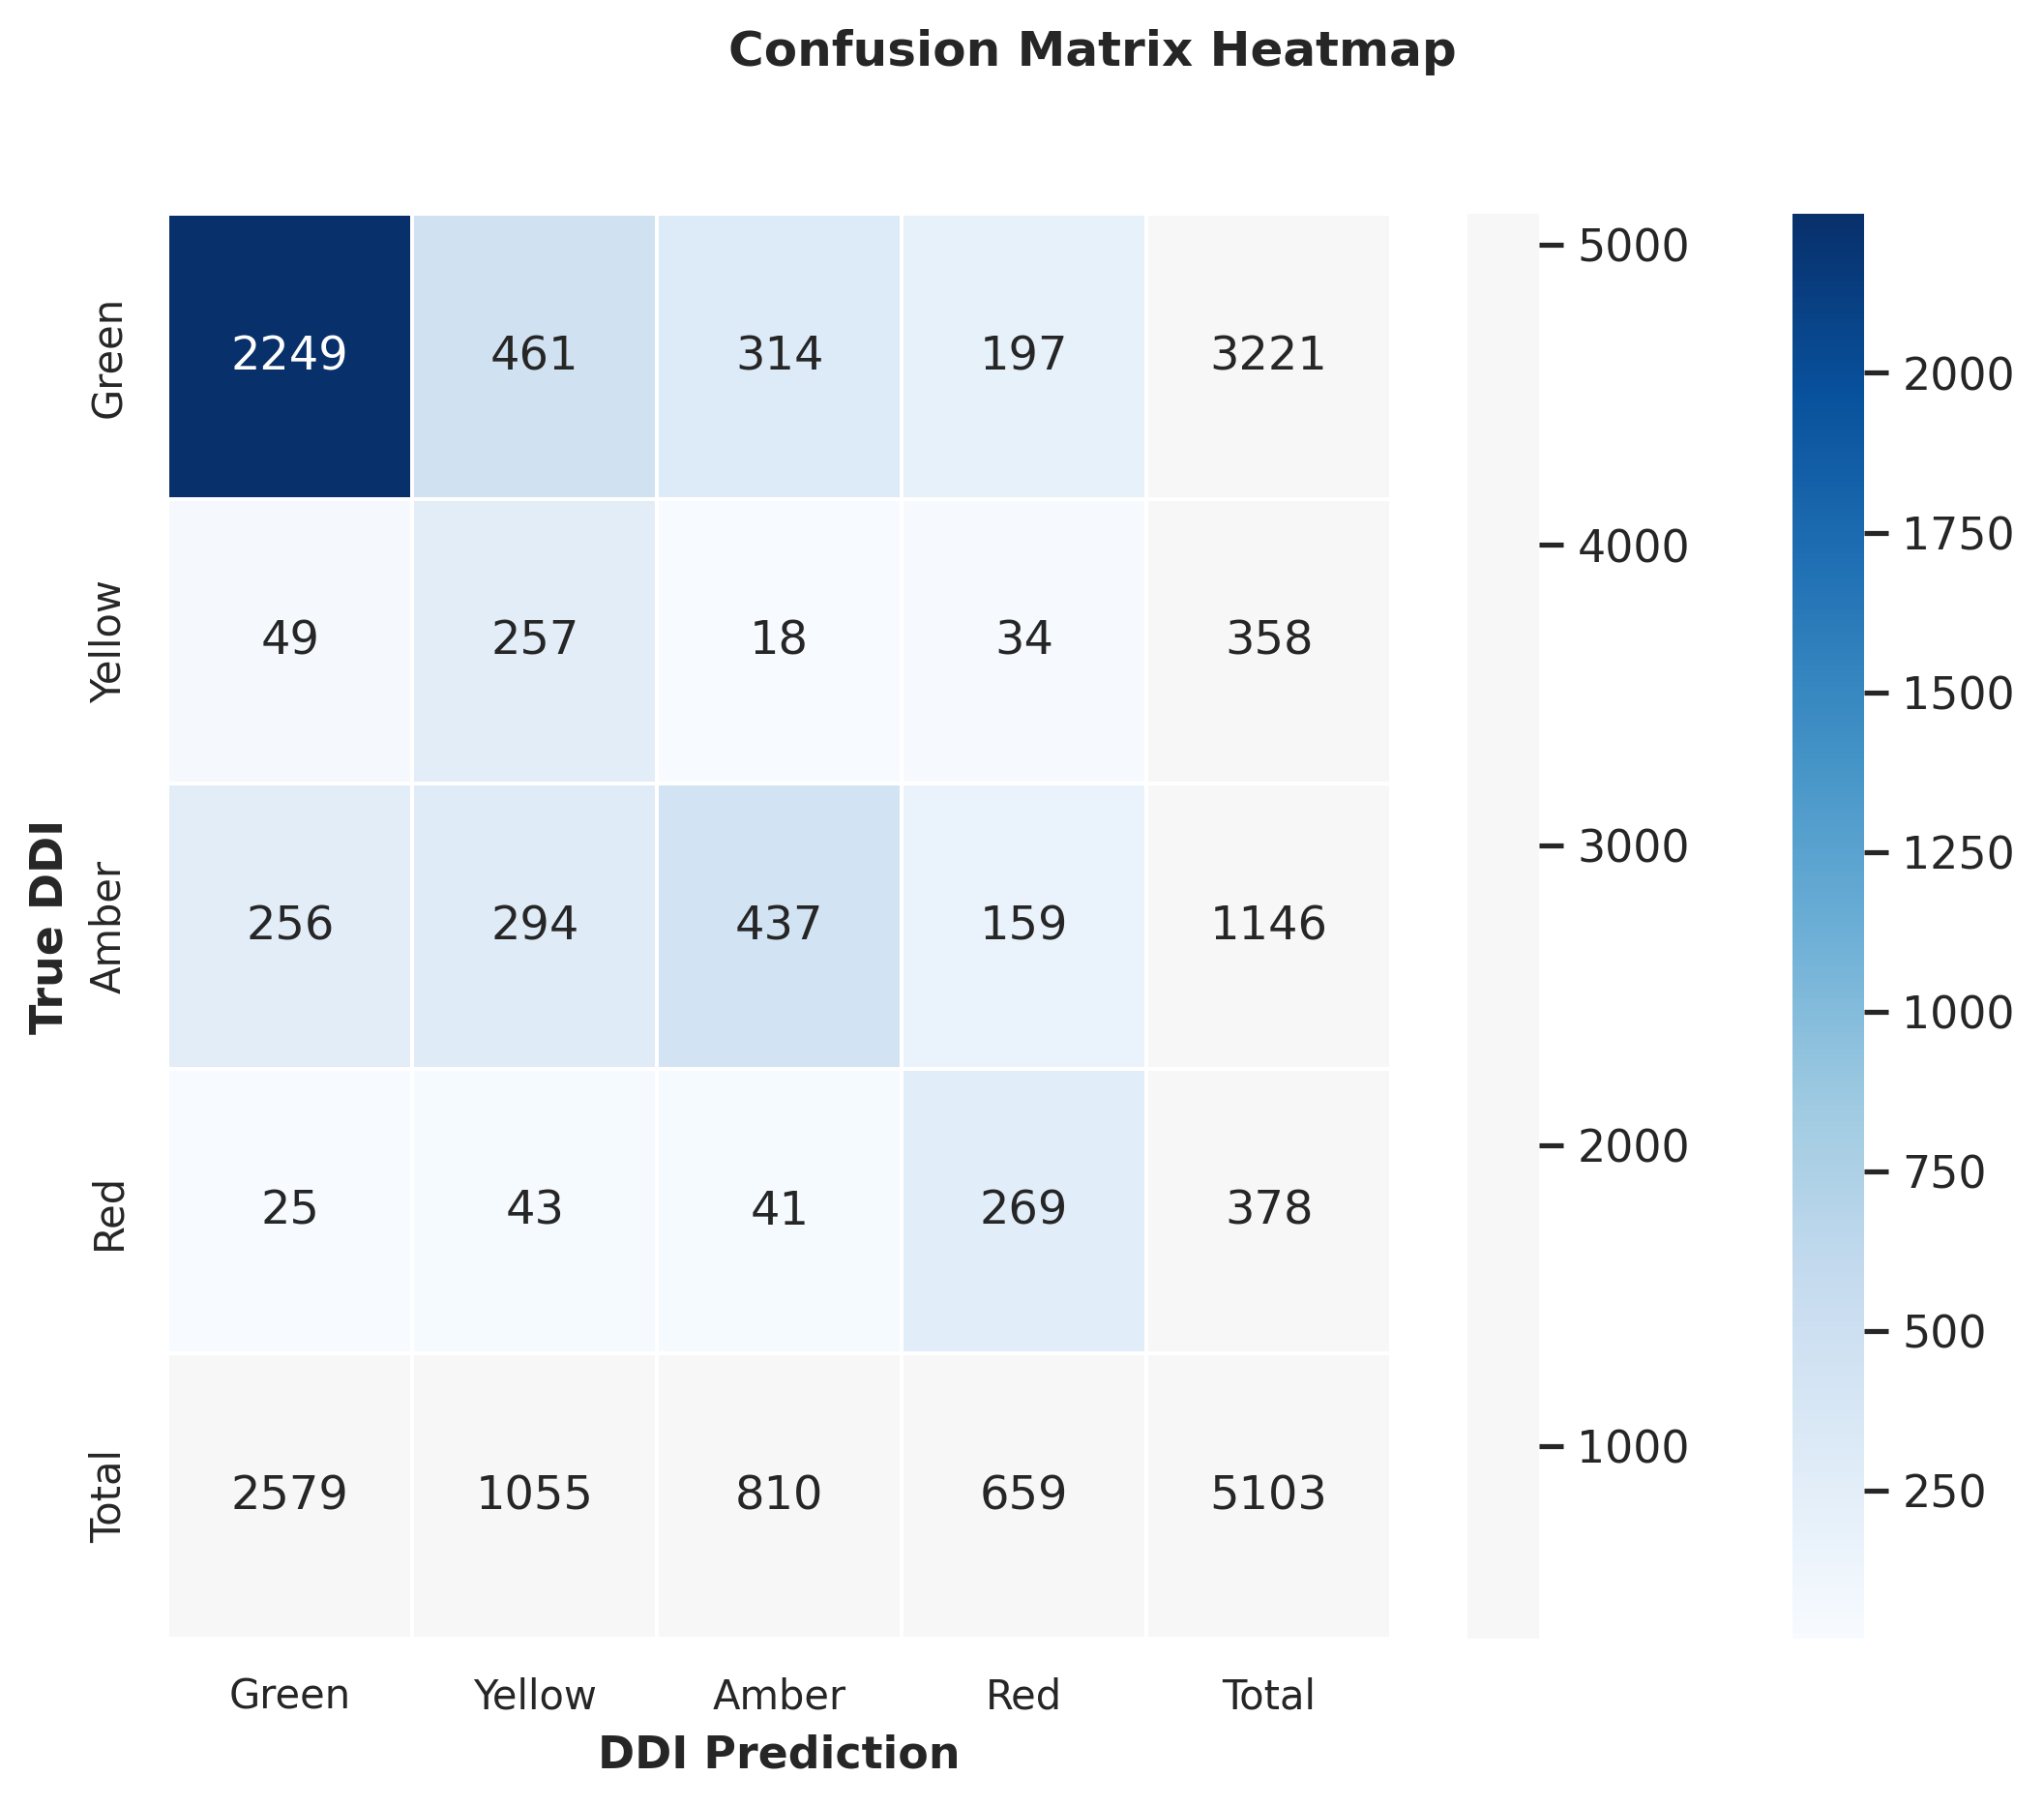

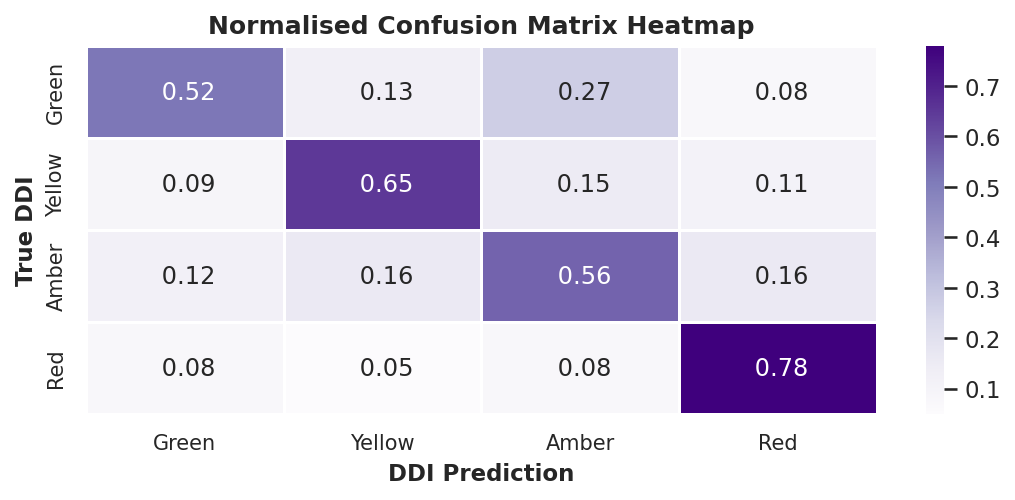

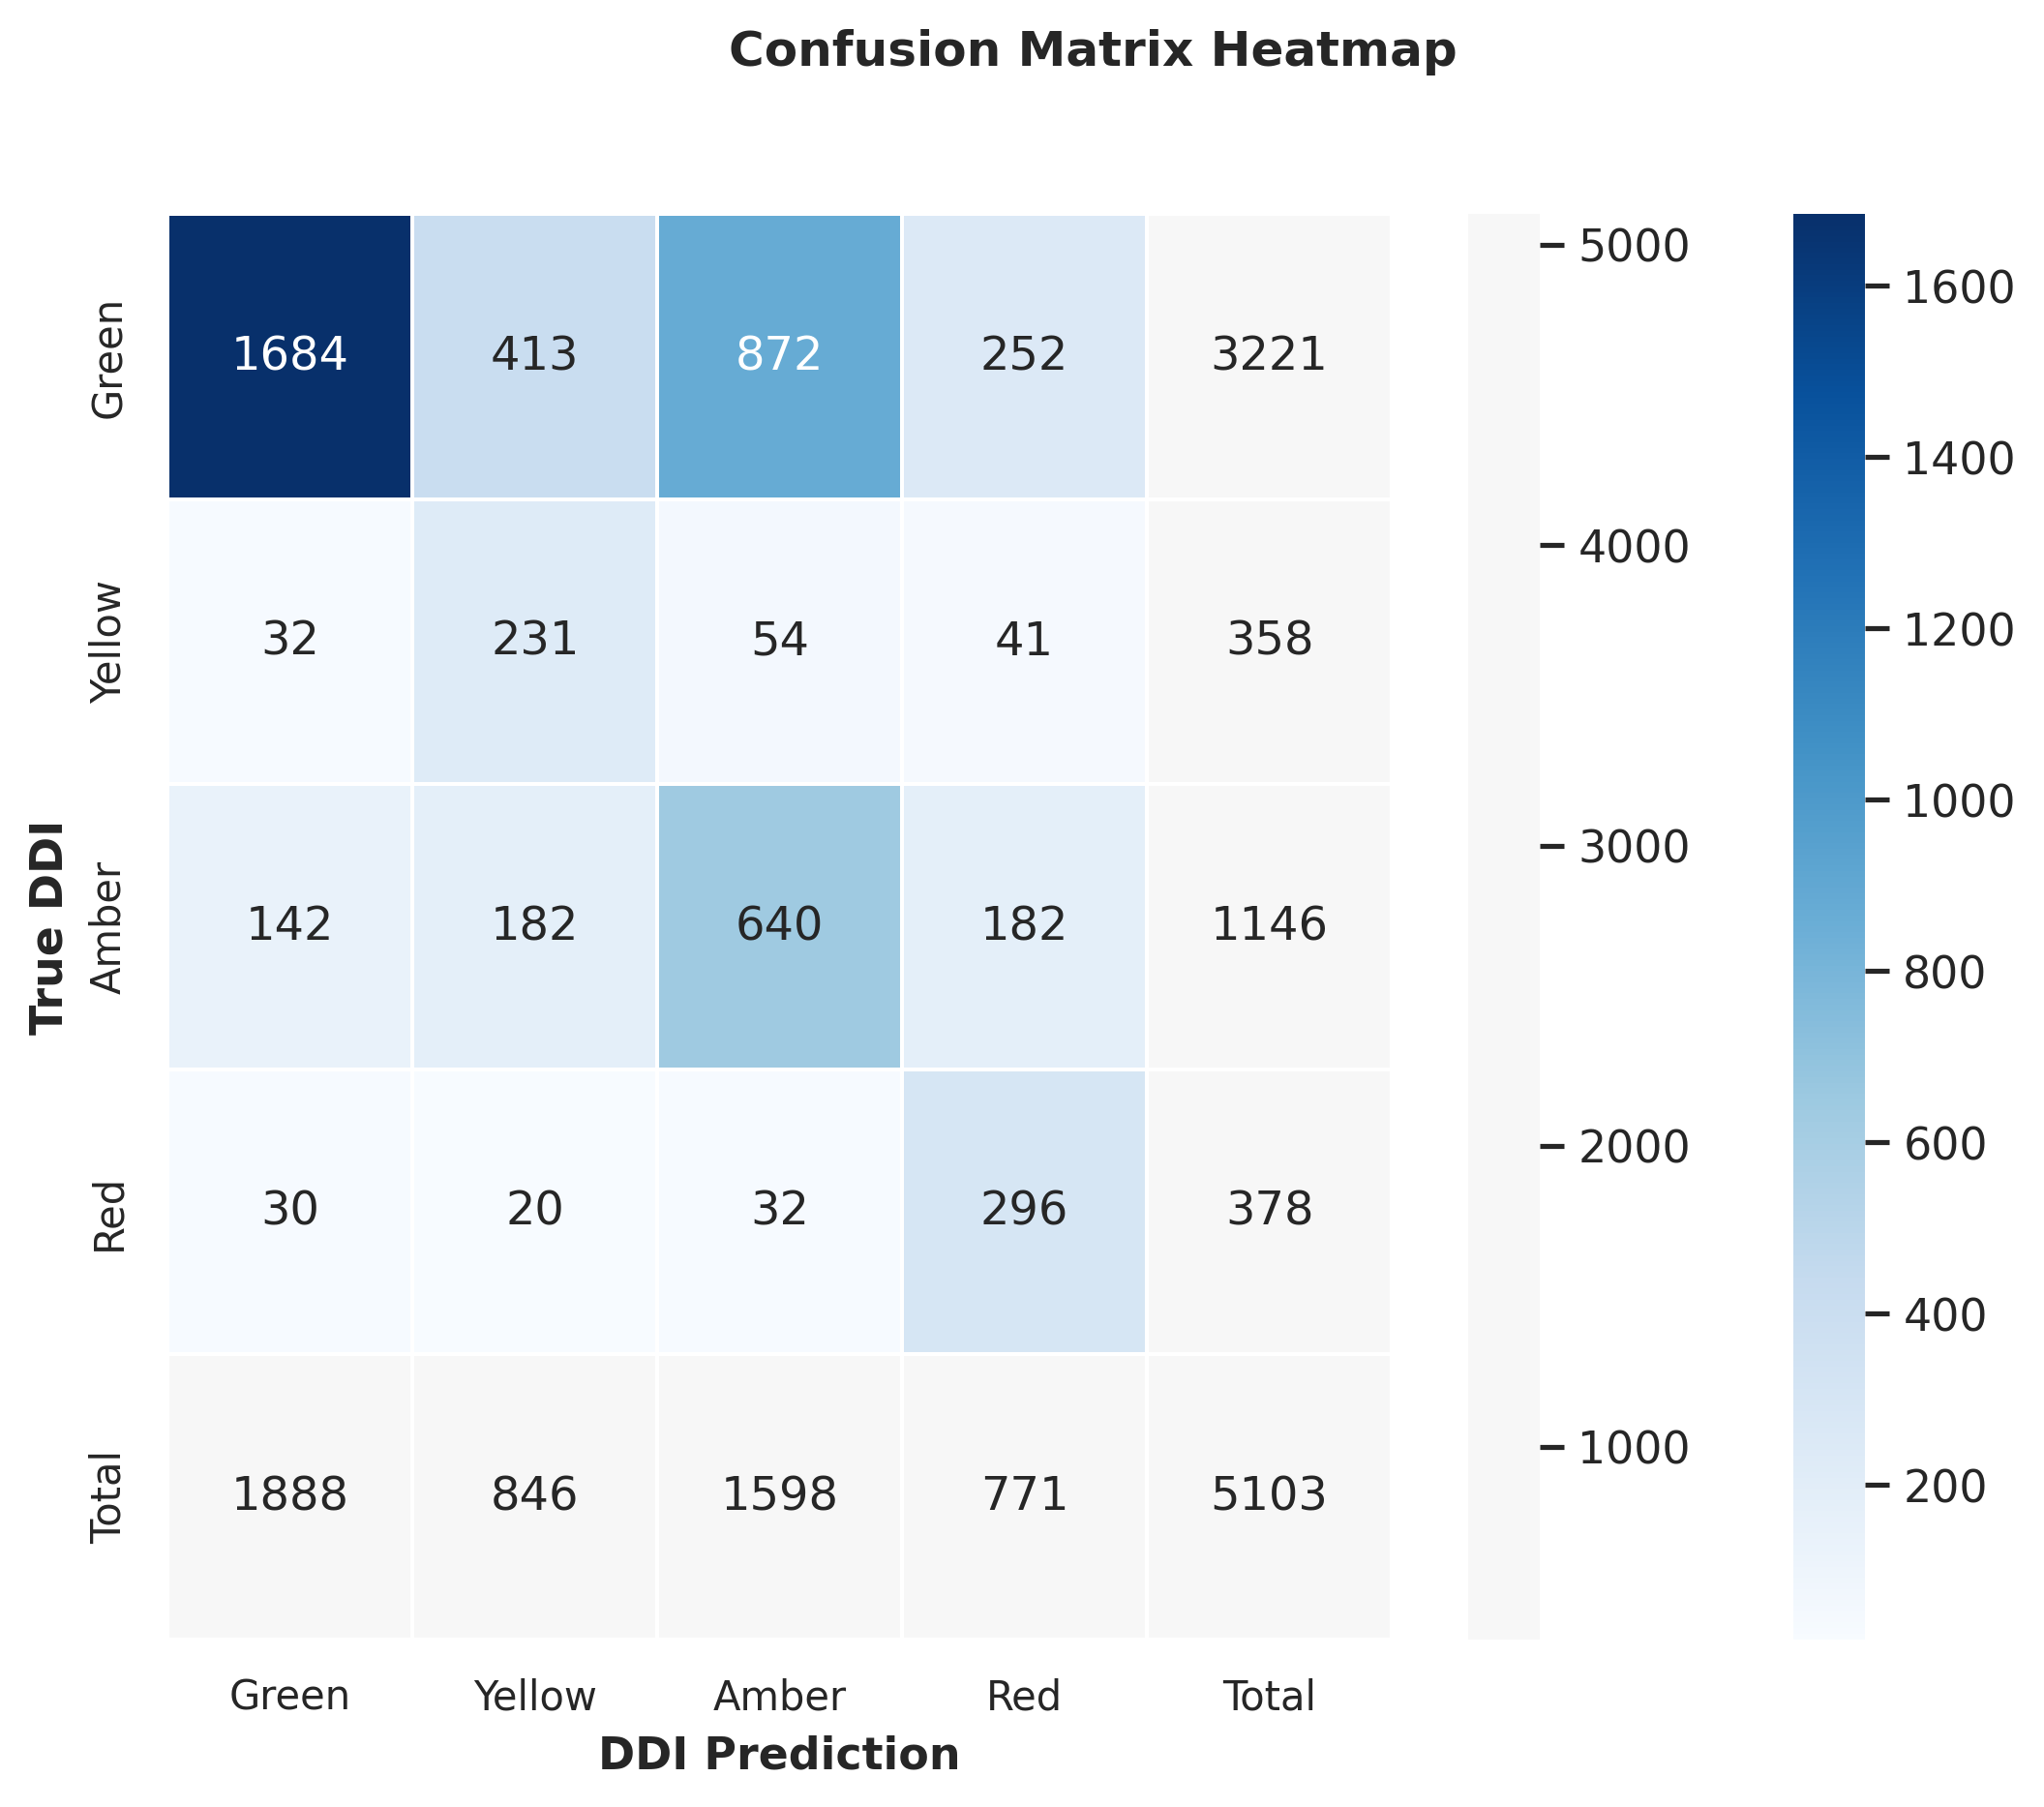

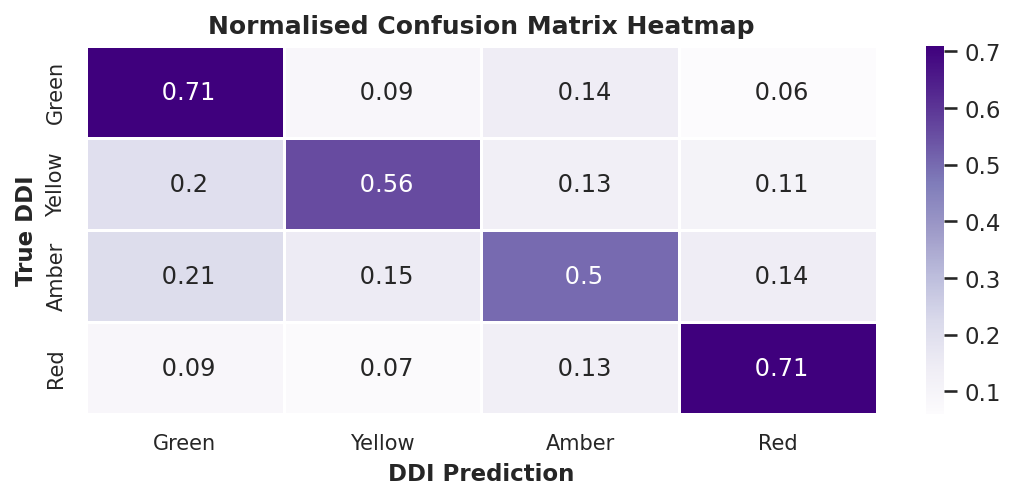

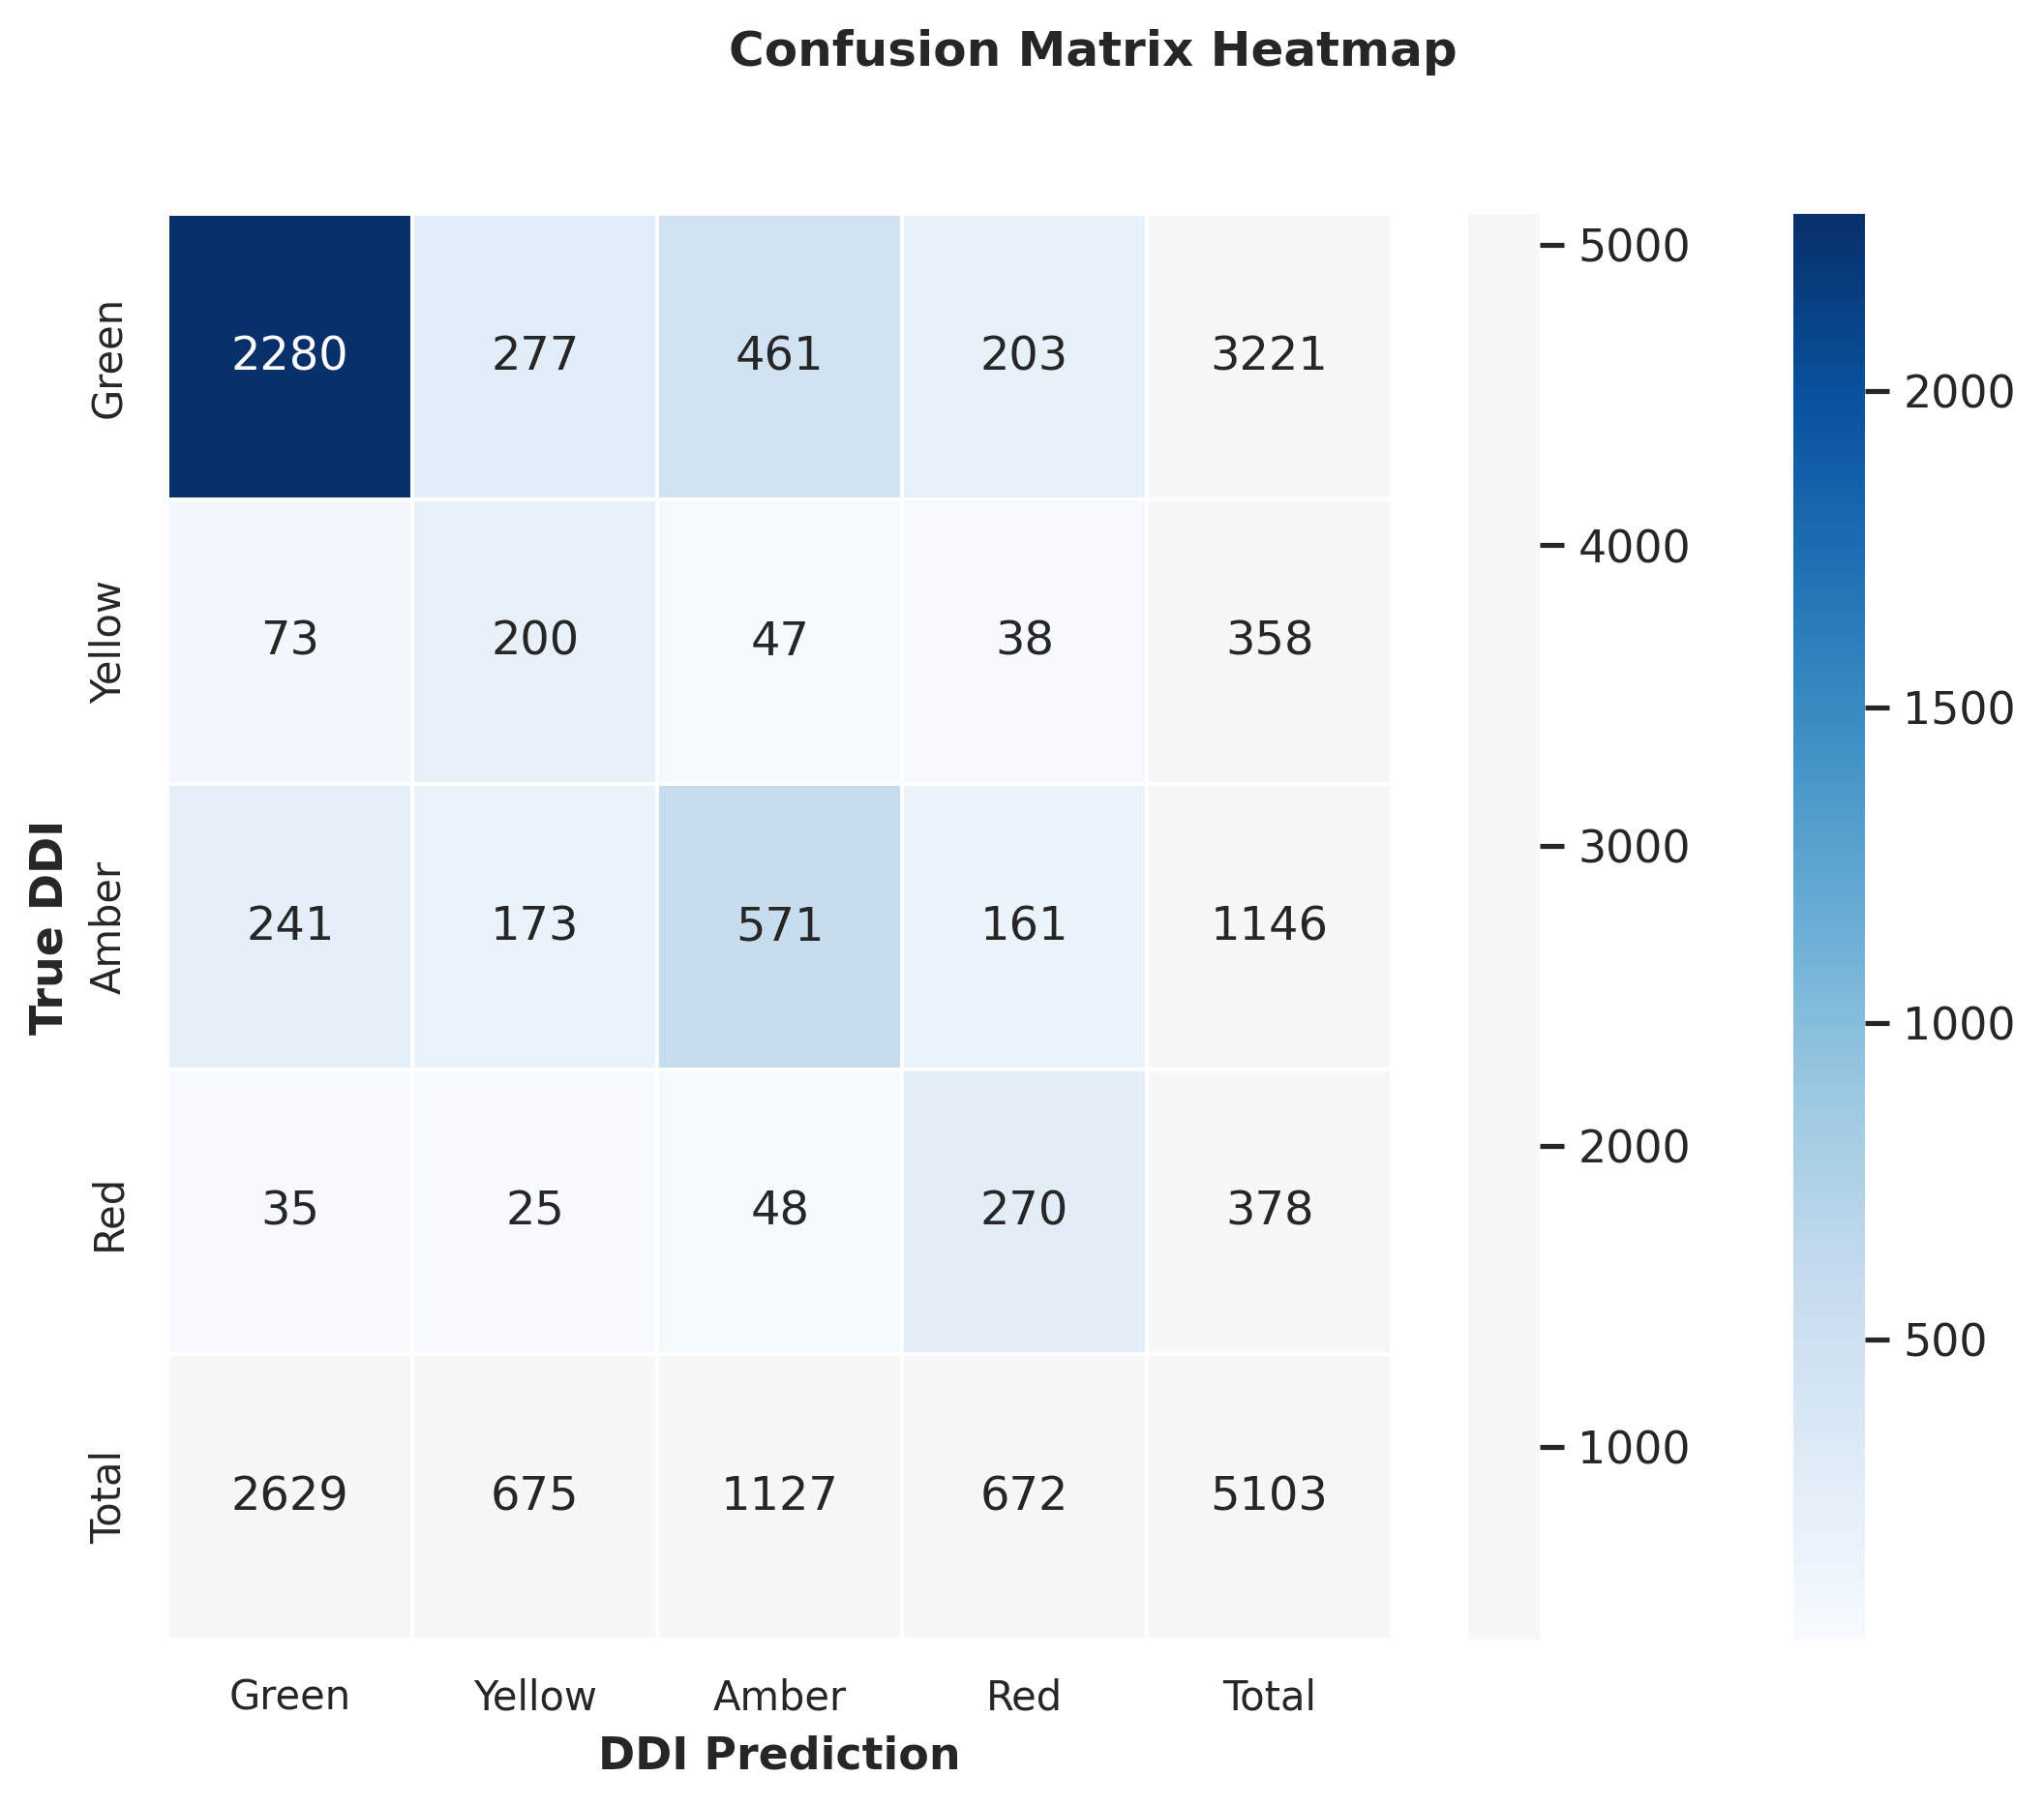

In [32]:
all_model_results, vote, confidence_score = DeepARV_evaluation()

In [37]:
avg_re = list(all_model_results.values())
#mean_df = pd.concat(avg_re).groupby(level=0).mean()

# Assuming all_results_model is your dictionary of DataFrames
# Replace all_results_model with your actual dictionary

# Check that all DataFrames have the same structure
assert all(df.shape == list(all_model_results.values()
                            )[0].shape for df in all_model_results.values())

# Stack DataFrames into a 3D array along a new axis (axis=2)
stacked_data = np.dstack([df.values for df in all_model_results.values()])

# Calculate the mean along the third axis (axis=2)
mean_values = np.mean(stacked_data, axis=2)

# Create a DataFrame with the calculated mean
mean_df = pd.DataFrame(mean_values, columns=list(all_model_results.values()
                                                 )[0].columns)

# Calculate the standard deviation along the third axis (axis=2)
std_deviation = np.std(stacked_data, axis=2)

# Create a DataFrame with the calculated standard deviation
std_dev_df = pd.DataFrame(std_deviation, columns=list(all_model_results.values()
                                                      )[0].columns)

# Display evaluation metrics
print('Evaluation table for rows - Green (0), Yellow (1), Amber (2), Red (3) and weighted average (4)')
print('\n Macro average')
print(mean_df)
print('\n Standard deviation')
print(std_dev_df)

Evaluation table for rows - Green (0), Yellow (1), Amber (2), Red (3) and weighted average (4)

 Macro average
   accuracy  precision  sensitivity  specificity  f1-score  balanced accuracy
0   0.71924    0.86490      0.65966      0.82116   0.74564            0.74040
1   0.86224    0.28714      0.61790      0.88066   0.38838            0.74928
2   0.75910    0.47640      0.48308      0.83902   0.47258            0.66104
3   0.90100    0.40536      0.70952      0.91634   0.51484            0.81292
4   0.81038    0.70308      0.62078      0.83638   0.64216            0.72858

 Standard deviation
   accuracy  precision  sensitivity  specificity  f1-score  balanced accuracy
0  0.032021   0.017767     0.069538     0.039765  0.044322           0.020100
1  0.023280   0.030688     0.064952     0.029833  0.016220           0.017941
2  0.027290   0.048851     0.071558     0.053548  0.022024           0.014791
3  0.005802   0.012526     0.046996     0.009940  0.004392           0.018614
4  0.01599

<Figure size 3588x2018.25 with 0 Axes>

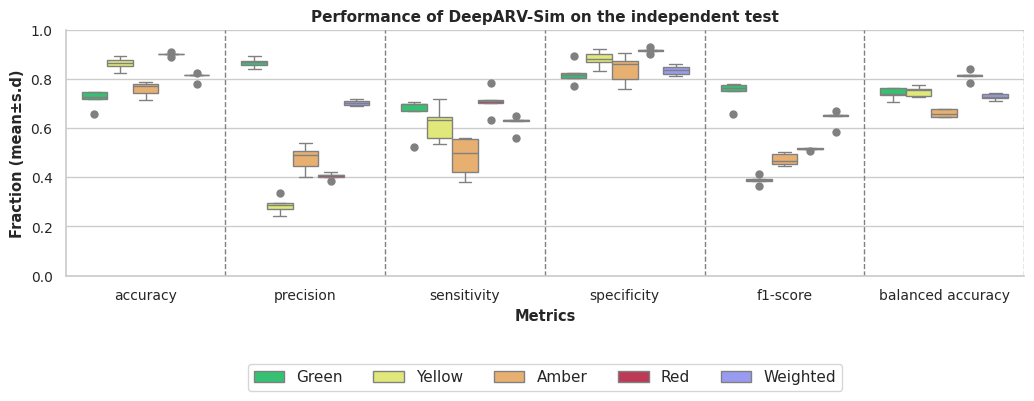

In [39]:
data = []
for model, df in all_model_results.items():
    for metric in df.columns:
        for class_ in df.index:
            data.append([f"Model {model + 1}", class_, metric, df.loc[class_, metric]])

# Create dataframe
columns = ['Model', 'Class', 'Metrics', 'Value']
result_df = pd.DataFrame(data, columns=columns)

# Plotting----------
sns.set(style="whitegrid")
# Aspect ratio (e.g., 4:3 or 16:9)
aspect_ratio =(16,9)
# Page size in inches (Letter size)
page_width_inch = 11.96
page_height_inch = 8.25/2
# Calculate the figure size
fig_width = page_width_inch  # Use full page width
fig_height = fig_width * aspect_ratio[1] / aspect_ratio[0]
plt.figure(figsize=(fig_width,fig_height), dpi=300)
# hue_order for the legend
hue_order = result_df['Class'].unique()
deepARV_plot = sns.catplot(data=result_df, x='Metrics', y='Value', hue='Class',
                           kind='box', hue_order = hue_order,
                           height=3.5, aspect=3,
                           boxprops=dict(edgecolor='grey'),
                           whiskerprops=dict(color='grey'),
                           capprops=dict(color='grey'),
                           medianprops=dict(color='grey'),
                           flierprops=dict(markerfacecolor='grey',
                                           markeredgecolor='grey'),
                           palette=dict(Green='#1ED86F',
                                        Yellow='#F1FA68',
                                        Amber='#FCB15C',
                                        Red='#D12548',
                                        Weighted="#8A8EFD"), legend_out=False)
deepARV_plot.set(ylim=(0, 1))
deepARV_plot.tick_params(axis='x', labelsize=10)
deepARV_plot.tick_params(axis='y', labelsize=10)

plt.title('Performance of DeepARV-Sim on the independent test', size = 11,
          fontweight='bold')
plt.xlabel('Metrics', size=10.5,fontweight='bold')
plt.ylabel('Fraction (mean' + (u'\xb1') + 's.d)', size=10.5,fontweight='bold')
plt.tight_layout()

# vertical lines between metrics
for metric, position in zip(result_df['Metrics'].unique(), range(len(result_df[
    'Metrics'].unique()))):
    plt.axvline(x=position + 0.5, color='grey', linestyle='--', linewidth=1)

# legend box to the bottom
deepARV_plot.ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),
                       ncol=5)
# Show the plot
deepARV_plot.savefig('content\evaluation_result', dpi=300)
plt.show()

## Confusion matrix

Mean:
[[0.6598 0.1054 0.1704 0.0642]
 [0.1654 0.6178 0.1182 0.0984]
 [0.2084 0.1746 0.483  0.1338]
 [0.1016 0.0698 0.119  0.7096]]

Standard Deviation:
[[0.06951086 0.02700074 0.06128491 0.00783326]
 [0.04557455 0.06496584 0.04916666 0.0106132 ]
 [0.04705146 0.04684698 0.07151783 0.01705755]
 [0.02863983 0.02271035 0.03357976 0.04692377]]


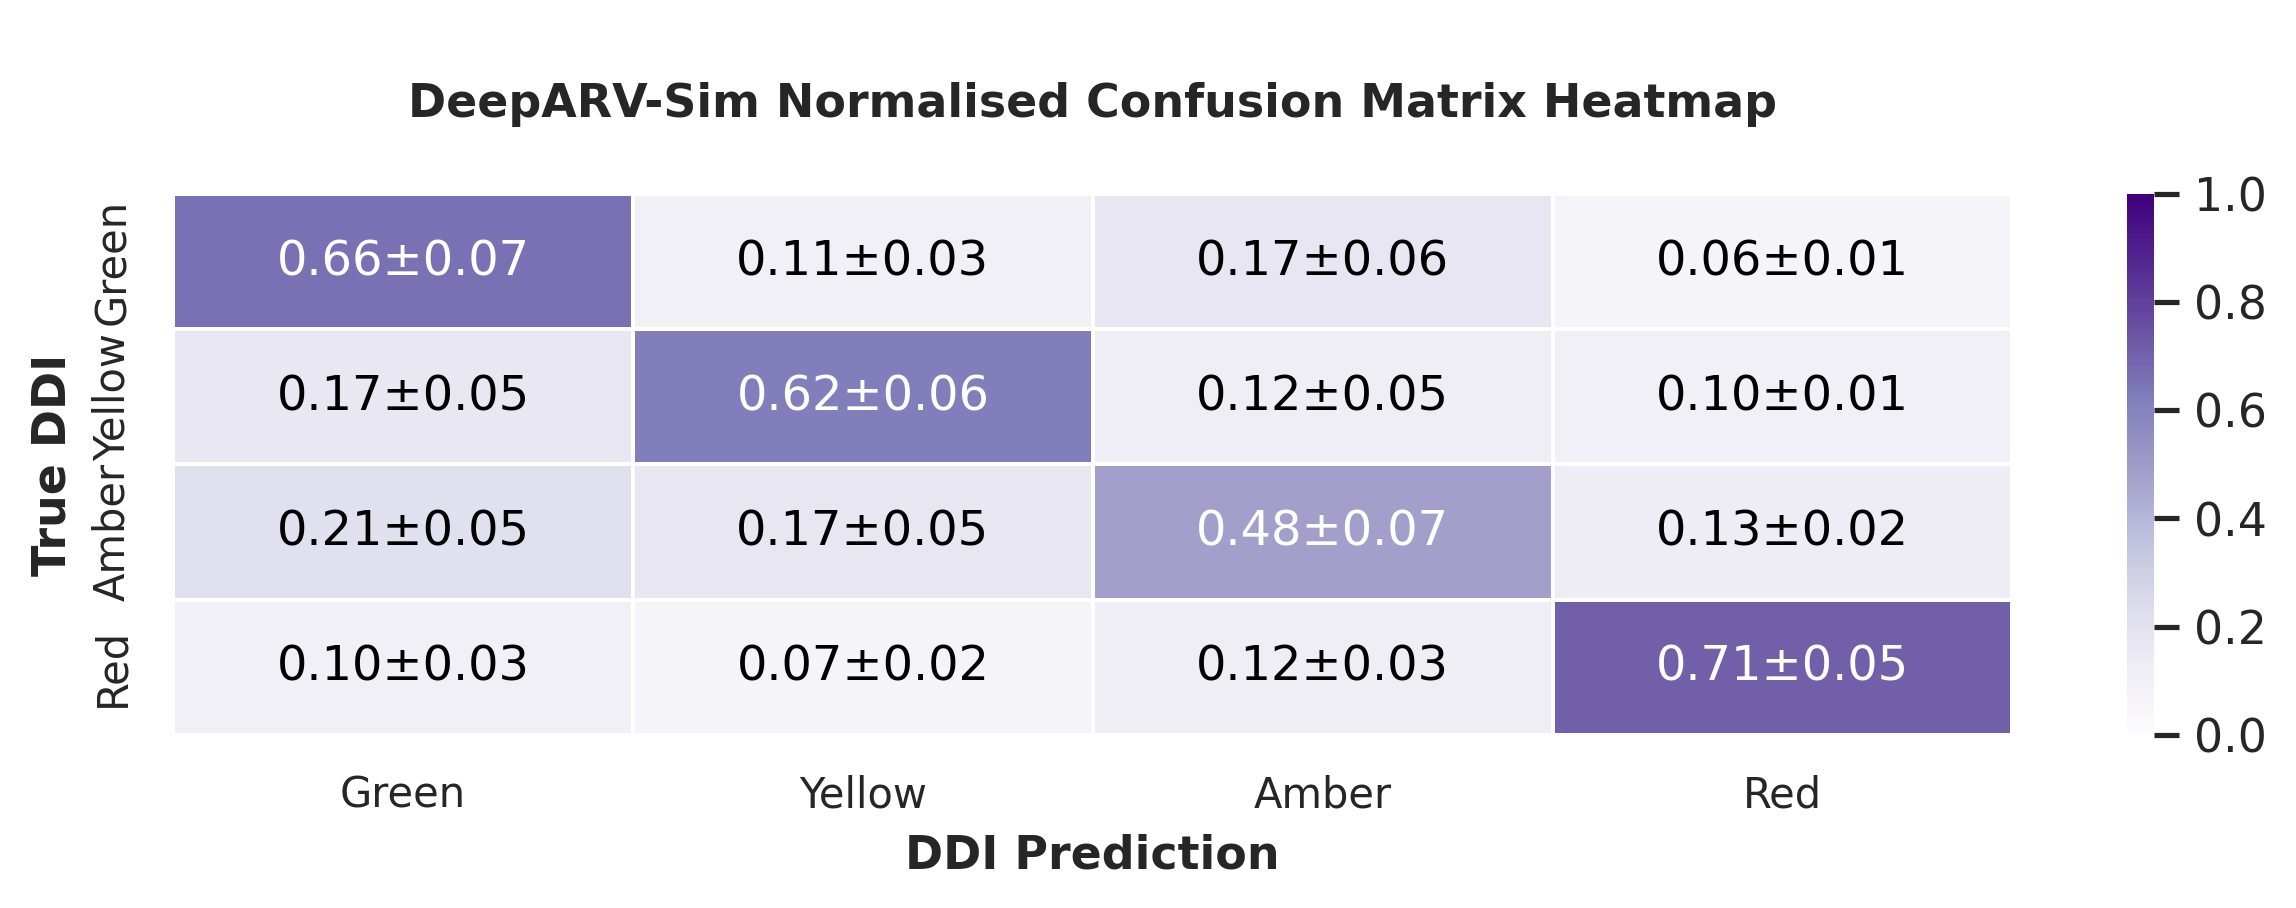

In [40]:
#plot mean of normalised cf from all models
y_test = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/Y_test_full.npy')
cf_dict = {}
cf_matrix_dict = {}
for i in range(5):
  cf_matrix = tf.math.confusion_matrix(y_test,vote[i], 4)
  cf_matrix_dict[i] = cf_matrix
  #cf_matrix = np.array(cf_matrix)
  cf_matrix_cal = np.array(cf_matrix)/np.sum(cf_matrix,axis=1)[:,np.newaxis]
  cf_matrix_normalised = np.around(cf_matrix_cal,3)
  cf_dict[i] = cf_matrix_normalised

# Calculate mean and standard deviation
mean_array = np.mean([cf_dict[key] for key in sorted(cf_dict.keys())], axis=0)
std_arr = np.std([cf_dict[key] for key in sorted(cf_dict.keys())], axis=0)
cf_matrix_mean = np.mean([cf_matrix_dict[key] for key in sorted(cf_matrix_dict.keys())], axis=0)

# Display the results
print("Mean:")
print(mean_array)
print("\nStandard Deviation:")
print(std_arr)

# Update final dictionary result
cf_dict['avg'] = mean_array
cf_dict['std'] = std_arr

# Combine mean and standard deviation into a single array
combined_array = np.vstack([mean_array, std_arr])
cf_matrix_normalised = mean_array

# Convert the combined array to strings for annotation
combined_str_array = np.array(
    [f"{avg:.2f}±{std:.2f}" for avg,
     std in zip(mean_array.flatten(), std_arr.flatten())]).reshape(mean_array.shape)

group_counts = [value for value in cf_matrix_normalised.flatten()]
labels = [f"{v1}"
          for v1 in
          group_counts]
labels= np.asarray(labels).reshape(len(cf_matrix_normalised),
                                    len(cf_matrix_normalised))
sns.set(font_scale=1)


xy_label = ['Green','Yellow','Amber','Red']
# Aspect ratio (e.g., 4:3 or 16:9)
aspect_ratio =(4, 3/2)

# Page size in inches (Letter size)
page_width_inch = 8.5
page_height_inch = 11

# Calculate the figure size
fig_width = page_width_inch  # Use full page width
fig_height = fig_width * aspect_ratio[1] / aspect_ratio[0]


plt.figure(figsize=(fig_width,fig_height), dpi=300)

# Create the heatmap without annotations
res = sns.heatmap(data=cf_matrix_normalised, cmap='Purples',
                  linewidths=0.5, linecolor='white',
                  xticklabels=xy_label, yticklabels=xy_label, vmin=0, vmax=1)

# Manually annotate the heatmap with combined_str_array
for i in range(len(xy_label)):
    for j in range(len(xy_label)):
      text_color = "white" if cf_matrix_normalised[i,j] > 0.4 else "black"
      res.text(j + 0.5, i + 0.5, combined_str_array[i, j],
                 ha='center', va='center', fontsize=11.5, color=text_color)
res.tick_params(axis='x', labelsize=10)
res.tick_params(axis='y', labelsize=10)
plt.xlabel('DDI Prediction', size=11,fontweight='bold')
plt.ylabel('True DDI', size=11,fontweight='bold')
plt.title('\n DeepARV-Sim Normalised Confusion Matrix Heatmap \n', fontsize=11,
          fontweight='bold')
plt.tight_layout()
plt.savefig('CM_DeepARV_Sim', dpi=300)

## AUROC

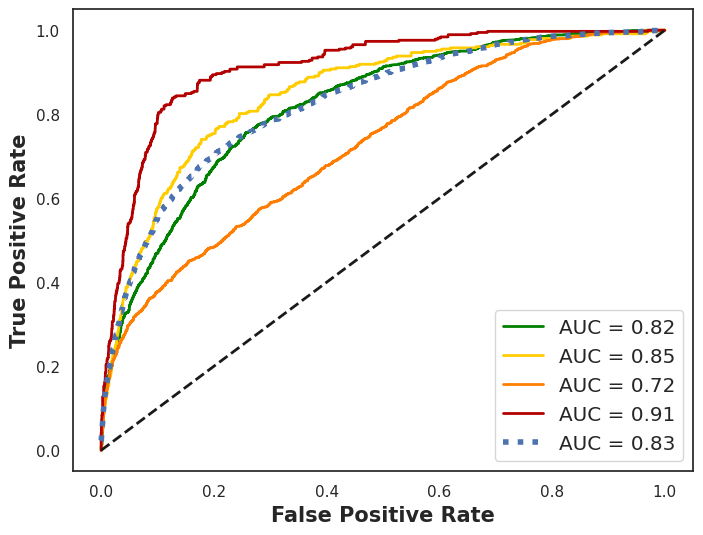

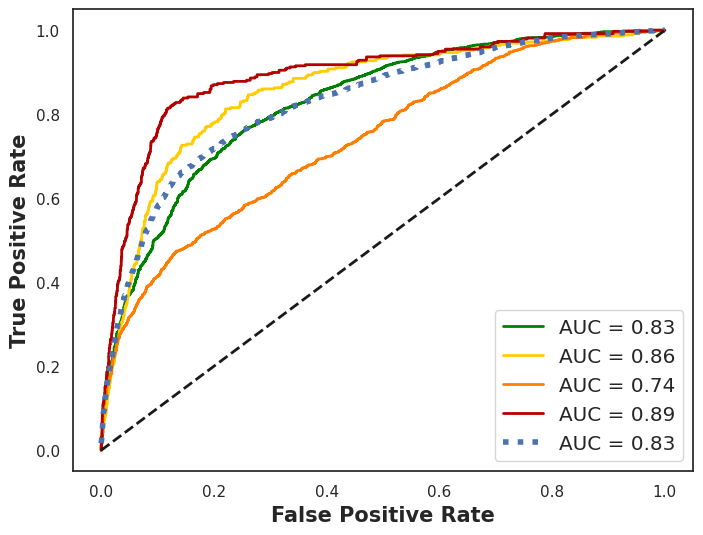

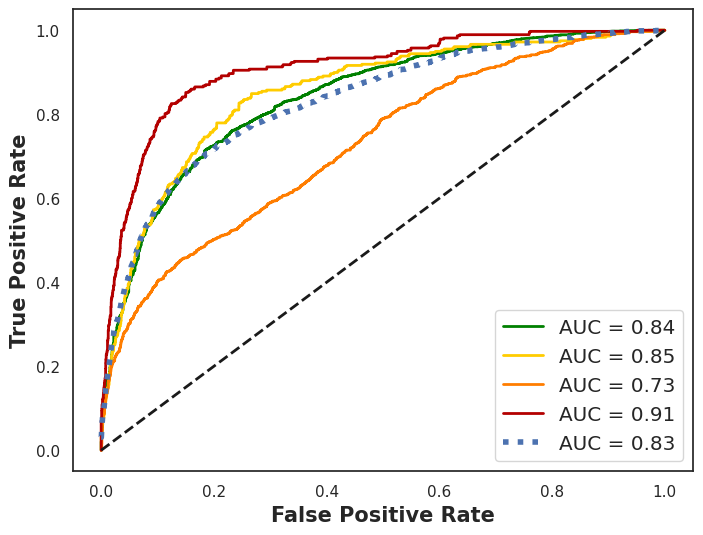

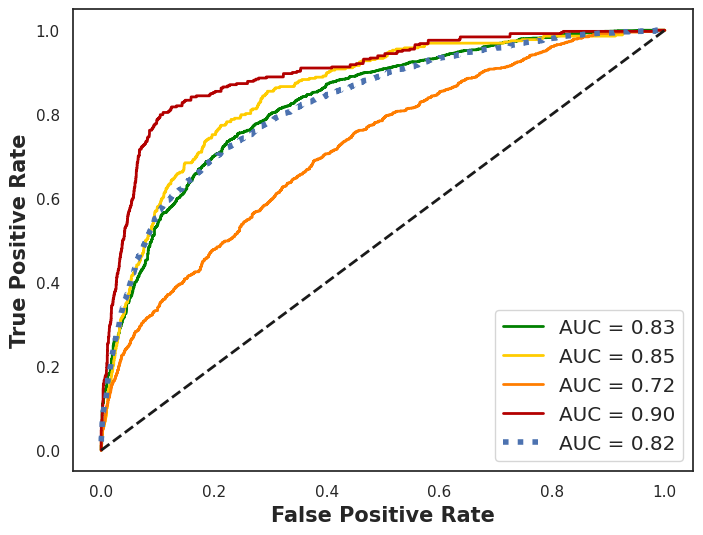

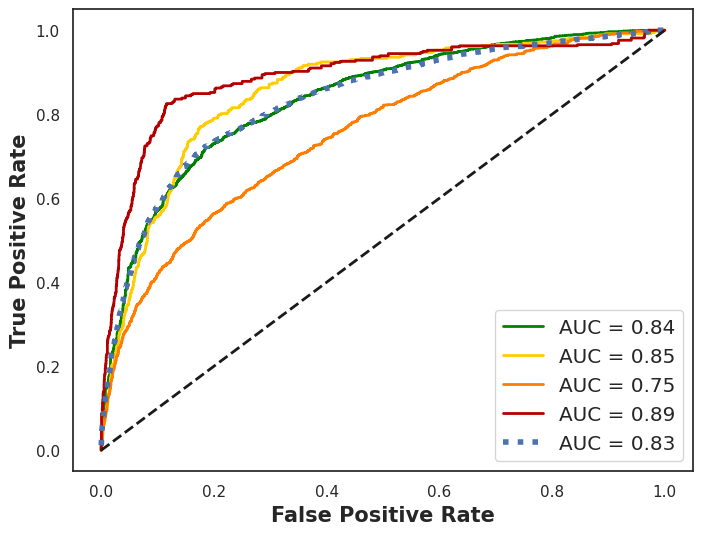

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
sns.set(style="white")

y_test = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/Y_test_full.npy')
label_binarizer = LabelBinarizer()
y_test = label_binarizer.fit_transform(y_test)

def plotAUROC(soft_vote, y_test, save_filename=None):
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  n_classes = 4
  ensemble_proba = soft_vote

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ensemble_proba[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute macro-average ROC curve and ROC area
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Interpolate all ROC curves
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Average and calculate AUC
  mean_tpr /= n_classes
  macro_auc = auc(all_fpr, mean_tpr)

  fig, ax = plt.subplots(figsize=(8, 6))

  # Class name and colour
  class_label = ['Green', 'Yellow', 'Amber', 'Red']
  class_colour = {0: 'Green', 1: (1.0, 0.8, 0.0), 2: (1.0, 0.49, 0.0),
                  3: (0.7, 0.0, 0.0)}

  # Plot each class's ROC curve
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], lw=2,
              label='AUC = {:.2f}'.format(roc_auc[i], class_label[i]),
              color=class_colour.get(i, 'blue'))

  # Plot macro-average ROC curve
  ax.plot(all_fpr, mean_tpr,
          label='AUC = {:.2f}'.format(macro_auc),
          linestyle=':', linewidth=4)

  ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
  ax.set_xlabel('False Positive Rate', size=15, fontweight='bold')
  ax.set_ylabel('True Positive Rate', size=15, fontweight='bold')
  ax.legend(loc='lower right', fontsize='large')

  if save_filename is not None:
      fig.savefig(save_filename, dpi=300)
      plt.show()
      plt.close(fig)
  else:
      plt.show()

for i in range(5):
    plotAUROC(confidence_score[i], y_test, save_filename=f'sim_roc_{i}.png')

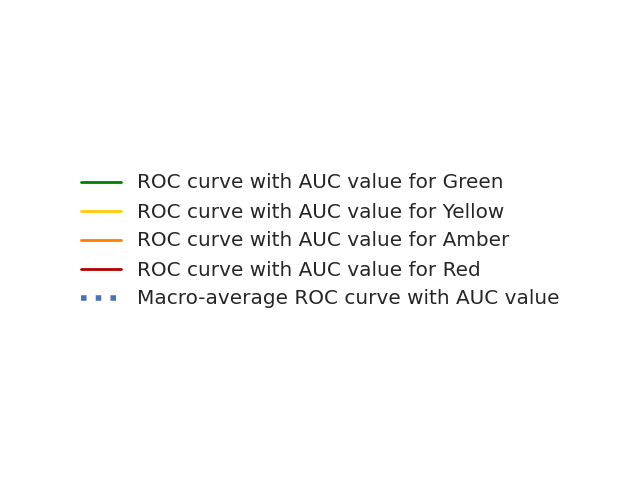

In [43]:
def plotLegend():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_axis_off()

    # Label
    class_label = ['Green', 'Yellow', 'Amber', 'Red']
    class_colour = {0: 'Green', 1: (1.0, 0.8, 0.0), 2: (1.0, 0.49, 0.0), 3: (0.7, 0.0, 0.0)}

    # Plot lines
    for i in range(len(class_label)):
        ax.plot([], [], lw=2,
                label='ROC curve with AUC value for {}'.format(class_label[i]),
                color=class_colour.get(i, 'blue'))

    # Plot dummy
    ax.plot([], [], linestyle=':', linewidth=4,
            label='Macro-average ROC curve with AUC value'.format(0.0))
    legend = ax.legend(loc='center', fontsize='large', frameon=False)
    legend.get_frame().set_edgecolor('grey')
    plt.savefig('legend_roc.png', dpi=300)
    plt.show()

plotLegend()